In [1]:
import math
import random
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import numba
import numpy.random
from collections import deque

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [24]:
class GridWorld:
    def __init__(self, taille, position_start, good_end_position, bad_end_position):
        self.current_state = position_start  # État actuel (ligne, colonne)
        self.states = [[x, y] for x in range(taille[0]) for y in range(taille[1])]
        self.end_good_state = good_end_position  # État final (ligne, colonne)
        self.end_bad_state = bad_end_position
        self.grid_size = taille  # Taille de la grille (lignes, colonnes)
        self.stateSpace = {}
        self.matchStates()
        self.currentIntState = self.getStateInt(self.current_state)
        self.num_actions = 4  # Nombre total d'actions possibles (haut, bas, gauche, droite)
        self.reward = 0  # Récompense actuelle
        self.done = False  # Indique si la partie est terminée
        self.generate_grid()
        self.actions = [0, 1, 2, 3]
        self.rewards = [0, 1, 3]
        self.actionSpace = {0: -self.grid_size[0], 1: self.grid_size[0],
                            2: -1, 3: 1}

    
    def reset(self):
        self.done = False
        self.current_state = [np.random.randint(0,self.grid_size[0]-1), np.random.randint(0,self.grid_size[1]-1)]
        self.currentIntState = self.getStateInt(self.current_state)
        self.reward = 0
        
    def matchStates(self):
        i=0
        for s in self.states:
            self.stateSpace[str(s)] = i
            i = i+1
    
    def getStateInt(self, st):
        return self.stateSpace[str(st)]
    
    def getStateCouple(self, st):
        n_state = {i for i in self.stateSpace if self.stateSpace[i]==st}
        return list(n_state)
        
    
    def step(self, action):
        if action == 0:
            if self.current_state[0] == 0 :
                self.current_state[0] = self.grid_size[0] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour traverser le mur
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[0] = self.current_state[0] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 1:
            if self.current_state[0] == self.grid_size[0] - 1:
                self.current_state[0] = 0
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else :
                self.current_state[0] = self.current_state[0] + 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 2:
            if self.current_state[1] == 0:
                self.current_state[1] = self.grid_size[1] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[1] = self.current_state[1] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 3:
            if self.current_state[1] == self.grid_size[1] - 1:
                self.current_state[1] = 0
                self.currentIntState = self.getStateInt(self.current_state)
                #print(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[1] = self.current_state[1] + 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
                # Si l'on atteint l'état final, la partie est terminée
        return self.currentIntState, self.reward, self.done

    def endgame(self):
        if self.current_state == self.end_good_state:
            self.reward = 10  # Récompense de 1 pour atteindre l'état final
            self.done = True
        elif self.current_state == self.end_bad_state:
            self.reward = -10
            self.done = True

    # def update_grid(self):
    #     new_grid = [["_", "_", "_", "_"],
    #                 ["_", "_", "_", "_"],
    #                 ["_", "_", "_", "_"],
    #                 ["_", "_", "_", "_"]]
    #     new_grid[self.current_state[0]][self.current_state[1]] = "X"
    #     for i in new_grid:
    #         print(i)

    def generate_grid(self):
        grid=[]
        for i in range(self.grid_size[0]):
            grid.append([])
            for j in range(self.grid_size[1]):
                grid[i].append("_")
        grid[self.current_state[0]][self.current_state[1]] = "X"
        for i in grid:
            print(i)
        print("\n")
    

In [5]:
def build_compile_model(env):
    model = tf.keras.models.Sequential()
    model.add(Dense(24, input_dim=1, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(len(env.actions), activation='linear'))

    model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    return model

In [25]:
def dqn(env, episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.1):
    q_network = build_compile_model(env)
    nb_steps = 0
    first_episode = True
    
    step = 0
    reward = 0
    reward_per_episode = []
    step_by_episode = []
    
    for episode in range(episodes):
        env.reset()
        print("Episode : ", episode)
        cumumated_reward = 0
        done = False
        current_state = env.currentIntState
        while not done:
            actions = env.actions

            q_values = q_network.predict(np.array([current_state]))[0]
            if np.random.rand() < epsilon:
                a = np.random.choice(actions)
            else:
                a= np.argmax(q_values)

            old_reward = env.reward
            new_state, reward, done = env.step(a)
            print(done)

            q_values[a] = reward + gamma * np.amax(q_network.predict(np.array([new_state]))[0])
            q_network.fit(np.array([current_state]), np.array([q_values]), verbose=0)
            current_state = new_state
            
            step += 1
            cumumated_reward += reward
            if done:
                reward_per_episode.append(cumumated_reward)
        print(reward_per_episode)
    return reward_per_episode

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


Episode :  0
1/1 [==============================] - 0s 65ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 48ms/step
[9]
Episode :  1
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_'

1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 49ms/step
[9, -24, -37]
Episode :  3
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', 

1/1 [==============================] - 0s 33ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 36ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 29ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 31ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 52ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11]
Episode :  9
1/1 [==============================] - 0s 26ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [=======================

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36]
Episode :  15
1/1 [==============================] - 0s 21ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 31ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10]
Episode :  16
1/1 [==============================] - 0s 22ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


Fal

1/1 [==============================] - 0s 22ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33]
Episode :  20
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_',

1/1 [==============================] - 0s 29ms/step
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 48ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25]
Episode :  23
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 37ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_'

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16]
Episode :  37
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] -

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 22ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69]
Episode :  40
1/1 [==============================] - 0s 33ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 21ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10]
Episode :  41
1/1 [==============================] - 0s 23ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
[

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 36ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2]
Episode :  46
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11

1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 21ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7]
Episode :  61
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_',

1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 37ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31]
Episode :  62
1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_',

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 25ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2]
Episode :  72
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 40ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10]
Episode :  74
1/1 [=============================

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5]
Episode :  87
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', 

1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 37ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1]
Episode :  90
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_',

1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 26ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6]
Episode :  101
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_']
['

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9]
Episode :  104
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
['_', '_', '

1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 26ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 26ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0]
Episode :  114
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [=========================

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 25ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14]
Episode :  124
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 27ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 30ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11

1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 117ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 30ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -9

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 24ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9]
Episode :  139
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['X', '_', '_', '_']
['_', 

1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 29ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 53ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 50ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 29ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 33ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 24ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 25ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 24ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -2

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 28ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 35ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 22ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 25ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 67ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -2

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -2

1/1 [==============================] - 0s 29ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -28, 7, 4, -14, 8, -12, 8, -6, 7, -7, 7, 7, 6, -15, -18, 8, 8, 8, -6, 8, -13, 8, 7, -11, -21, 8, -79, 4, 8, 7, 6, 6, -19, -3, 8, 9, 5, 0, 8]
Epis

1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -2

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 21ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 36ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 25ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 21ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 39ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 38ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -28, 7, 4, -14, 8, -12, 8, -6, 7, -7, 7, 7, 6, -15, -18, 8, 8, 8, -6, 8, -13, 8, 7, -11, -21, 8, -79, 4, 8, 7, 6, 6, -19, -3, 8, 9, 5, 0, 8, 1, -

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 29ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 24ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 34ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -2

1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 25ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 21ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 25ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 25ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15

1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 41ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 24ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 21ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 34ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 34ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 26ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -28, 7, 4, -14, 8, -12, 8, -6, 7, -7, 7, 7, 6, -15, -18, 8, 8, 8, -6, 8, -13, 8, 7, -11, -21, 8, -79, 4, 8, 7, 6, 6, -19, -3, 8, 9, 5, 0, 8, 1, -

1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 29ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15

1/1 [==============================] - 0s 30ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 24ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -2

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 34ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 37ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -28, 7, 4, -14, 8, -12, 8, -6, 7, -7, 7, 7, 6, -15, -18, 8, 8, 8, -6, 8, -13, 8, 7, -11, -21, 8, -79, 4, 8, 7, 6, 6, -19, -3, 8, 9, 5, 0, 8, 1, -12, 7, -51, -13, -15, 8, 6, 9, 6, 6, -13, 8, 9, 4, -

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 32ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11

1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 39ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15

1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


1/1 [==============================] - 0s 27ms/step
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 34ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15

1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 27ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 22ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 21ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -2

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 34ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 21ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 21ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -2

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 23ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 43ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11

1/1 [==============================] - 0s 35ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 45ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -2

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 53ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 28ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15

1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 25ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


True
1/1 [==============================] - 0s 48ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96

1/1 [==============================] - 0s 32ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 34ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 21ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 26ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15

1/1 [==============================] - 0s 25ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7, -7, 8, -16, 6, -9, 1, -7, 7, -6, 4, -11, 7, -10, 5, -15, -7, 3, -13, 7, -23, 8, -15, 6, -12, 9, -29, 4, -18, -3, -4, -3, -1, -4, -18, 9, 5, -28, 7, 4, -14, 8, -12, 8, -6, 7, -7, 7, 7, 6, -15, -18, 8, 8, 8, -6, 8, -13, 8, 7, -11, -21, 8, -79, 4, 8, 7, 6, 6, -19, -3, 8, 9, 5, 0, 8, 1, -

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


True
1/1 [==============================] - 0s 28ms/step
[9, -24, -37, -71, -15, -35, -11, -13, -11, -20, -13, -10, -26, -11, -36, -10, 4, -11, 5, -33, 5, -6, -25, -21, -24, -15, -10, -10, -11, -13, -13, -36, -13, -13, -14, -13, -16, 3, -20, -69, -10, -15, -11, -15, 0, 2, -55, -11, -96, -5, 0, -16, 6, 8, -39, 4, -13, -10, 8, 4, 7, -31, 3, 6, -6, -21, 8, 7, 1, -44, 2, 2, -8, -10, 5, 5, -17, -2, -6, 3, 4, -11, -6, 2, -8, 5, 5, -12, 8, 1, -21, -1, 6, 3, -17, 1, -10, -3, 7, -24, -6, 8, -18, 9, -9, 7, -14, 7, 7, -6, 1, 8, 6, 0, -1, 5, -14, 6, -5, -12, 5, -9, 7, -14, 5, -15, 7, -8, -9, 8, -32, 5, 8, -23, 8, 7, -19, 4, -9, -11, -7, 9, -19, 7, -10, 7, -14, 5, 8, -30, 5, 9, -14, 6, -2, -3, 7, -16, -7, 6, -9, 9, -17, 7

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 31ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


False
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


False
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


False
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


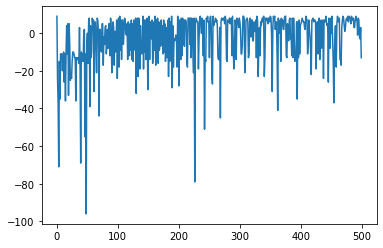

In [26]:
if __name__ == '__main__':
    world = GridWorld([4,4], [3,3], [3,3], [0,0])
    scores = dqn(world, episodes = 500)
    plt.plot(scores)